In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import community.community_louvain as community_louvain
import networkx as nx
import pandas as pd
import numpy as np
from qiime2 import Artifact
from skbio.stats.composition import clr
from scipy.stats import pearsonr, kruskal, spearmanr
import seaborn as sns

%matplotlib inline

**Filter based on [Inferring Correlation Networks from Genomic Survey Data](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002687) Friedman and Alm (2012)**

In [11]:
tax_p_df = Artifact.load("Data/tax-6-psuedo-table.qza").view(pd.DataFrame)

tax_p_df = tax_p_df.loc[:, ( (tax_p_df.sum() > 501) & (tax_p_df.mean() > 3) )]

**Convert to relative abundances**

In [12]:
tax_mat = np.matrix(tax_p_df)
tax_mat /= np.sum(tax_mat, axis=1)

tax_p_df = pd.DataFrame(tax_mat,
                   index=tax_p_df.index,
                   columns=tax_p_df.columns)

**Apply center log ratio transformation, create pearson correlation matrix, filter based on r > 0.5, p < 0.05**

In [13]:
tax_df_clr = pd.DataFrame(clr(tax_p_df),
                          index=tax_p_df.index,
                          columns=tax_p_df.columns)

clr_pear = tax_df_clr.corr()

links = clr_pear.stack().reset_index()
links.columns = ['var1', 'var2', 'value']


links_filtered=links.loc[ (links['value'] > 0.5) & (links['var1'] != links['var2']) ]

for ind in links_filtered.index:
    r, p = pearsonr(tax_df_clr[links_filtered.loc[ind,"var1"]],
                    tax_df_clr[links_filtered.loc[ind,"var2"]])
    if p > 0.05:
        links_filtered.drop(ind, inplace=True)

In [14]:
links_filtered

,var1,var2,value
120,d__Archaea;p__Euryarchaeota;c__Methanobacteria...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.575444
127,d__Archaea;p__Euryarchaeota;c__Methanobacteria...,d__Bacteria;p__Synergistota;c__Synergistia;o__...,0.517309
247,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,d__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.508103
504,d__Bacteria;p__Actinobacteriota;c__Coriobacter...,d__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.993719
844,d__Bacteria;p__Actinobacteriota;c__Coriobacter...,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.540045
...,...,...,...
16376,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.624094
16439,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.501063
16497,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.744563
16505,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.624094


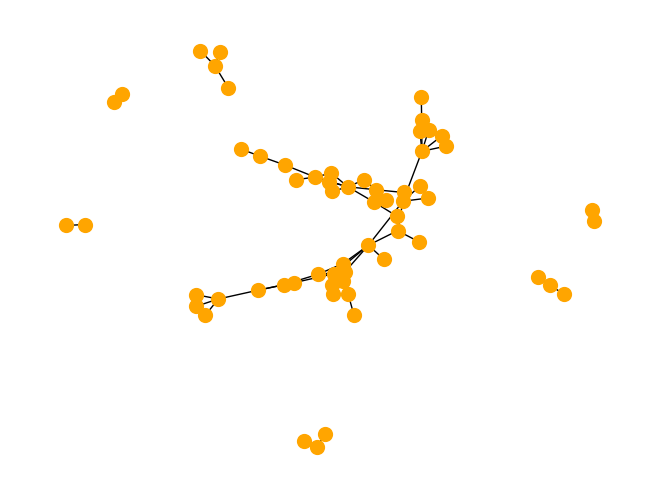

In [15]:
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2',)

nx.draw(G, node_color='orange', node_size=80, edge_color='black', linewidths=2)

plt.show()


**Use Louvain method to partition into modules, create figure**

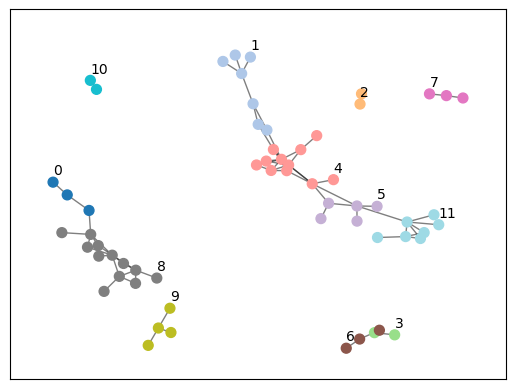

In [17]:
partition = community_louvain.best_partition(G, random_state=42)

pos = nx.spring_layout(G, k=0.17, seed=42)
# color the nodes according to their partition
cmap = cm.get_cmap('tab20')

nx.draw_networkx_nodes(G, pos, nodelist=partition.keys(), 
                       node_size=50,
                       cmap=cmap, 
                       node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)

#collapse the dict to get one in each module 
#then annotate the plot with their module number 
#there's probably a better way to do this but this works for now
for v, k in {v:k for k,v in partition.items()}.items():
    plt.annotate(text=v,
                 xy=(pos[k][0], pos[k][1]+0.05))
    
ax = plt.gca()
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], ylim[1]+0.1)

plt.savefig("Figures/Main-Network.pdf")
plt.show()

In [18]:
np.unique(list(partition.values()))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [19]:
#make a list of each taxon in each module
rev_part = {i: list(dict(filter(lambda x: x[1]==i, partition.items())).keys()) for i in range(len(partition))}

modules_df = pd.DataFrame.from_dict(rev_part, orient="index").T

In [20]:
modules_df.to_csv("Tables/tax_clr_pearson_modules.csv")

## Now add metabolites

In [21]:
metabo = pd.read_csv("Data/IBS-ID-list.txt", sep="\t", encoding='unicode_escape')

#Clean up rows and columns
metabo = metabo[metabo["Sample"].isna()==False]
metabo.loc[metabo["Subject ID.1"].isna(), "Subject ID.1"] = metabo.loc[metabo["Subject ID.1"].isna(), "Sample"]
metabo.set_index("Subject ID.1", inplace=True)
metabo.drop(["Sample", "Subject ID","Unnamed: 3"], axis=1, inplace=True)

#Clean up column names
metabo.columns = list(metabo.columns[:2]) + [" ".join(col.split(" ")[:-4]) for col in list(metabo.columns[2:])]

#Impute NQ as LLOQ/2
metabo.replace(to_replace="NQ",
               value=np.nan,
               inplace=True)

metabo.loc["LLOQ", "Sample Weight"] = 0
metabo.loc["LLOQ",:] = metabo.loc["LLOQ",:].astype(float)
metabo.loc["half LLOQ",:] = metabo.loc["LLOQ"]/2
metabo.iloc[2:-1,:] = metabo.iloc[2:-1,:].fillna(metabo.loc["half LLOQ",:])

#Drop ULOQ/LLOQ
metabo.drop(["half LLOQ","LLOQ","ULOQ", "Preservative", "BLOQ Values", "ALOQ Values"], inplace=True)

#We can drop these too - quantities are already microg/g sample weight
metabo.drop(["Sample Weight", "Date and Time"], axis=1, inplace=True)

In [22]:
#indexes are the same
print(len(set(metabo.index)&set(tax_df_clr.index))==len(tax_df_clr.index))

#reindex according to tax
metabo = metabo.reindex(tax_df_clr.index)

True


In [23]:
tax_clr_metabo = pd.concat([tax_df_clr, metabo],
                            axis=1)

In [24]:
tax_metabo_pear = tax_clr_metabo.corr()

links = tax_metabo_pear.stack().reset_index()
links.columns = ['var1', 'var2', 'value']


links_filtered=links.loc[ (links['value'] > 0.5) & (links['var1'] != links['var2']) ]

for ind in links_filtered.index:
    r, p = pearsonr(tax_clr_metabo[links_filtered.loc[ind,"var1"]],
                    tax_clr_metabo[links_filtered.loc[ind,"var2"]])
    if p > 0.05:
        links_filtered.drop(ind, inplace=True)

/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_79742/3151085799.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  tax_metabo_pear = tax_clr_metabo.corr()


In [25]:
links_filtered

,var1,var2,value
120,d__Archaea;p__Euryarchaeota;c__Methanobacteria...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.575444
127,d__Archaea;p__Euryarchaeota;c__Methanobacteria...,d__Bacteria;p__Synergistota;c__Synergistia;o__...,0.517309
252,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,d__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.508103
519,d__Bacteria;p__Actinobacteriota;c__Coriobacter...,d__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.993719
874,d__Bacteria;p__Actinobacteriota;c__Coriobacter...,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.540045
...,...,...,...
18041,stearic acid (18:0),d__Bacteria;p__Firmicutes;c__Clostridia;o__Osc...,0.599448
18061,stearic acid (18:0),d__Bacteria;p__Firmicutes;c__Clostridia;o__Pep...,0.584927
18085,stearic acid (18:0),myristic acid (14:0),0.528171
18086,stearic acid (18:0),pentadecanoic acid (15:0),0.648730


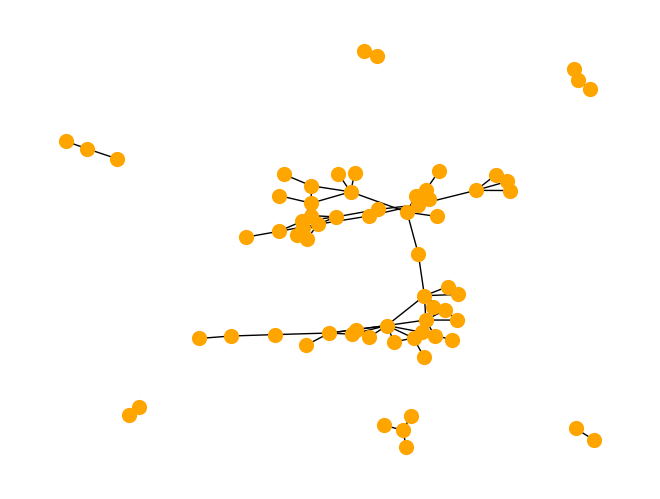

In [26]:
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2',)

nx.draw(G, node_color='orange', node_size=80, edge_color='black', linewidths=2)


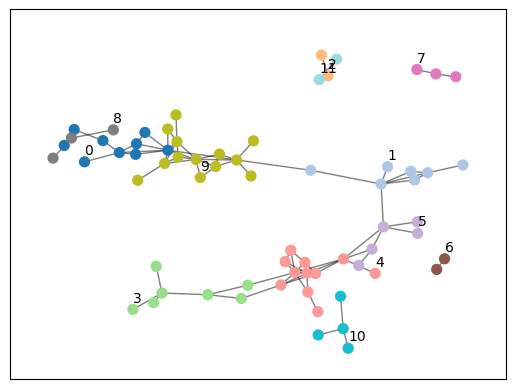

In [29]:
partition_m = community_louvain.best_partition(G, random_state=42)

pos = nx.spring_layout(G, k=0.2, seed=42)
# color the nodes according to their partition
cmap = cm.get_cmap('tab20')

nx.draw_networkx_nodes(G, pos, nodelist=partition_m.keys(), 
                       node_size=50,
                       cmap=cmap, 
                       node_color=list(partition_m.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)

#collapse the dict to get one in each module 
#then annotate the plot with their module number 
#there's probably a better way to do this but this works for now
for v, k in {v:k for k,v in partition_m.items()}.items():
    plt.annotate(text=v,
                 xy=(pos[k][0], pos[k][1]+0.05))
    
ax = plt.gca()
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], ylim[1]+0.1)

plt.savefig("Figures/Metabo-Network.pdf")
plt.show()

In [30]:
rev_part_m = {i: list(dict(filter(lambda x: x[1]==i, partition_m.items())).keys()) for i in range(len(partition_m))}

modules_df_m = pd.DataFrame.from_dict(rev_part_m, orient="index").T

In [31]:
modules_df_m.to_csv("Tables/tax_metabo_clr_pearson_modules.csv")

## Which are different in IBS?

In [32]:
tax_df = Artifact.load("Data/tax-6-table.qza").view(pd.DataFrame)

tax_mat = np.matrix(tax_df)
tax_mat /= np.sum(tax_mat, axis=1)

tax_df = pd.DataFrame(tax_mat,
                   index=tax_df.index,
                   columns=tax_df.columns)

In [33]:
for col in modules_df.columns:
    taxa = [i for i in modules_df[col].values if i] # "if i" removes None values 

    if len(taxa) > 0:

        module_sum = tax_df[taxa].sum(axis=1)

        tax_df[f"module{col}"] = tax_df[taxa].sum(axis=1)

In [34]:
modcolnames = list(tax_df.iloc[:,-12:].columns)

In [35]:
metadata = pd.read_csv("Data/IBS-metadata.txt", sep="\t", index_col="Sampleid")

In [36]:
print( len( set(tax_df.index)&set(metadata.index)) == len(tax_df.index ) )

#reindex according to tax
metadata = metadata.reindex(tax_df.index)

True


In [37]:
IBS_modules = pd.concat([metadata[["IBS", "IBS Type"]],
                        tax_df[modcolnames]],
                      axis=1)

In [38]:
for module in modcolnames:
    print(module)
    
    res = kruskal(IBS_modules.loc[IBS_modules["IBS"]=="Y", module],
                  IBS_modules.loc[IBS_modules["IBS"]=="N", module])
    if res.pvalue < 0.05:
        print("SIGNIFICANT")
        
    print(res, "\n")

module0
KruskalResult(statistic=0.475370218017267, pvalue=0.49052693582789964) 

module1
KruskalResult(statistic=0.37944664031618913, pvalue=0.5378995339339134) 

module2
KruskalResult(statistic=0.516528925619927, pvalue=0.47232611104501676) 

module3
KruskalResult(statistic=1.850461133069814, pvalue=0.17372977137950085) 

module4
KruskalResult(statistic=0.37944664031618913, pvalue=0.5378995339339134) 

module5
KruskalResult(statistic=0.8069828722002512, pvalue=0.36901377157758497) 

module6
KruskalResult(statistic=1.850461133069814, pvalue=0.17372977137950085) 

module7
KruskalResult(statistic=1.9210751696422605, pvalue=0.16573818274752866) 

module8
KruskalResult(statistic=0.5540184453227823, pvalue=0.4566803923316046) 

module9
SIGNIFICANT
KruskalResult(statistic=7.125164690382093, pvalue=0.007600943256664422) 

module10
KruskalResult(statistic=0.5928853754940633, pvalue=0.44130552592473027) 

module11
KruskalResult(statistic=2.17817379273995, pvalue=0.13998047407289602) 



**MODULE 9 is significantly different between IBS/control, here are its contents**

In [39]:
for i in modules_df[9].values:
    if i:
        print(i)

d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospiraceae_FCS020_group
d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospiraceae_ND3007_group
d__Bacteria;p__Firmicutes;c__Clostridia;o__Monoglobales;f__Monoglobaceae;g__Monoglobus
d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Subdoligranulum


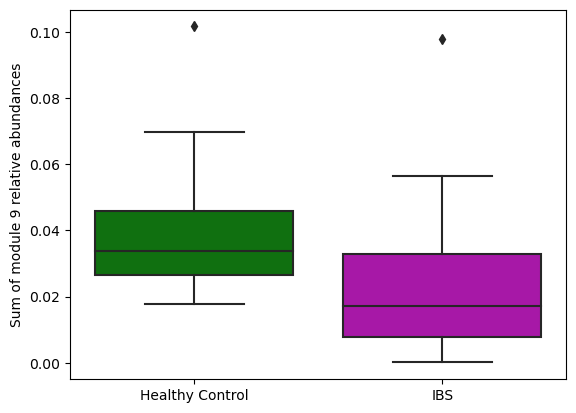

In [40]:
ax = sns.boxplot(x="IBS",
            y="module9",
            data=IBS_modules,
            palette=["g","m"])

ax.set_xticklabels(["Healthy Control", "IBS"])
ax.set_xlabel("")
ax.set_ylabel("Sum of module 9 relative abundances")

plt.savefig("Figures/IBS-Module-9.pdf")
plt.show()

In [41]:
for module in modcolnames:
    print(module)
    
    res = kruskal(IBS_modules.loc[IBS_modules["IBS Type"]=="control", module],
                  IBS_modules.loc[IBS_modules["IBS Type"]=="IBS-C", module],
                  IBS_modules.loc[IBS_modules["IBS Type"]=="IBS-M", module],
                  IBS_modules.loc[IBS_modules["IBS Type"]=="IBS-D", module])
    if res.pvalue < 0.05:
        print("SIGNIFICANT")
        
    print(res, "\n")

module0
KruskalResult(statistic=3.331845341687005, pvalue=0.34323490319694394) 

module1
KruskalResult(statistic=2.999955406911937, pvalue=0.39163205169921256) 

module2
KruskalResult(statistic=2.1924242424239995, pvalue=0.5334421003161416) 

module3
KruskalResult(statistic=5.01207729468598, pvalue=0.1709149185710945) 

module4
KruskalResult(statistic=0.6945373467112574, pvalue=0.8744880621778948) 

module5
KruskalResult(statistic=1.324005945745057, pvalue=0.7234406739353425) 

module6
KruskalResult(statistic=5.587328130806384, pvalue=0.13350773266767377) 

module7
KruskalResult(statistic=3.0478930911633926, pvalue=0.3842997868155168) 

module8
KruskalResult(statistic=5.146168710516548, pvalue=0.16140155669975986) 

module9
KruskalResult(statistic=7.725009290226694, pvalue=0.052050313935413796) 

module10
KruskalResult(statistic=5.978952062430324, pvalue=0.11263875544728646) 

module11
SIGNIFICANT
KruskalResult(statistic=13.715327518957533, pvalue=0.0033193992776818547) 



In [42]:
for i in modules_df[11].values:
    if i:
        print(i)

d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Defluviitaleaceae;g__Defluviitaleaceae_UCG-011
d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__UBA1819
d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Eisenbergiella
d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Hungatella
d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Anaerotruncus
d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Paludicola
d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__DTU089


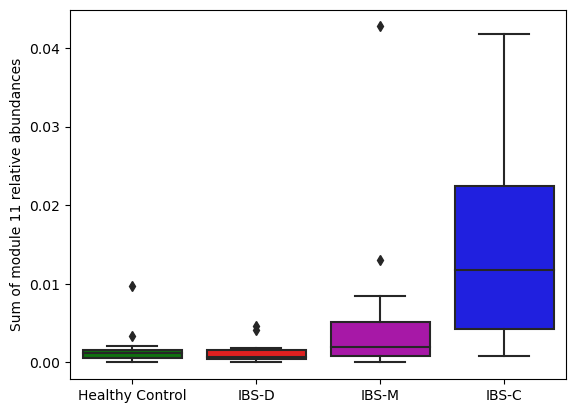

In [43]:
ax = sns.boxplot(x="IBS Type",
                y="module11",
                data=IBS_modules,
                order=["control","IBS-D","IBS-M","IBS-C"],
                palette=["g","r","m","b"])

ax.set_xlabel("")
ax.set_ylabel("Sum of module 11 relative abundances")
ax.set_xticklabels(["Healthy Control", "IBS-D", "IBS-M",  "IBS-C"])

plt.savefig("Figures/IBS-Type-Module-11.pdf")
plt.show()

## Which modules are associated with HFCS?

In [44]:
for module in modcolnames:
    print(module)
    
    res = spearmanr(IBS_modules.loc[:,module],
                    metadata.loc[:, "TOTAL EST HFCS (per year in grams)"])
    if res.pvalue < 0.05:
        print("SIGNIFICANT")
        
    print(res, "\n")

module0
SpearmanrResult(correlation=-0.010535414059476805, pvalue=0.9452389396128444) 

module1
SpearmanrResult(correlation=0.05362318840579709, pvalue=0.7264552463064566) 

module2
SpearmanrResult(correlation=-0.12174618838941847, pvalue=0.4256332312655743) 

module3
SpearmanrResult(correlation=0.05586297760210803, pvalue=0.7154997344375114) 

module4
SpearmanrResult(correlation=0.0530961791831357, pvalue=0.7290409705074559) 

module5
SpearmanrResult(correlation=0.2426877470355731, pvalue=0.1082071929911808) 

module6
SpearmanrResult(correlation=-0.035836627140974964, pvalue=0.8152104976246073) 

module7
SpearmanrResult(correlation=0.17984782117204184, pvalue=0.23713626638905752) 

module8
SpearmanrResult(correlation=-0.18471673254281945, pvalue=0.22446728480632896) 

module9
SpearmanrResult(correlation=-0.16772068511198945, pvalue=0.27078027403556654) 

module10
SpearmanrResult(correlation=-0.03768115942028985, pvalue=0.8058780545074444) 

module11
SpearmanrResult(correlation=0.19763

# LEfSe

## Prep

In [45]:
tax_df["IBS"] = metadata["IBS"]
tax_df["IBS-Type"] = metadata["IBS Type"]

In [46]:
tax_df.head()

,Unassigned;__;__;__;__;__,d__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter,d__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera,d__Archaea;p__Thermoplasmatota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomassiliicoccaceae;g__Methanomassiliicoccus,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Mobiluncus,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Alloscardovia,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Gardnerella,...,module4,module5,module6,module7,module8,module9,module10,module11,IBS,IBS-Type
HBC 104,0.0,0.0,0.0,0.0,0.000109,0.0,0.0,0.0,0.018277,0.0,...,0.260545,0.004427,0.055874,0.000461,0.032054,0.030490,0.026524,0.001249,N,control
HBC 106,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.011856,0.0,...,0.469885,0.008170,0.004884,0.002396,0.079811,0.035322,0.000000,0.001090,N,control
HBC 108,0.0,0.0,0.0,0.0,0.000131,0.0,0.0,0.0,0.016801,0.0,...,0.431086,0.007868,0.013794,0.001139,0.004467,0.101641,0.000321,0.000584,N,control
HBC 109,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.036572,0.0,...,0.456686,0.005936,0.013815,0.001393,0.004691,0.026751,0.017406,0.001356,N,control
HBC 111,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.031901,0.0,...,0.409468,0.016320,0.008763,0.002566,0.044906,0.069707,0.000703,0.003351,N,control


In [47]:
lefse_df = tax_df.drop(modcolnames, axis=1)

In [48]:
lefse_df.columns = ["|".join(x.split(";")) for x in lefse_df.columns]

### IBS/CTRL

In [49]:
lefse_df.drop("IBS-Type", axis=1).to_csv("Data/Lefse-IBS-notype-data.tsv", sep="\t", index=False)

In [50]:
lefse_df.head()

,Unassigned|__|__|__|__|__,d__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter,d__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera,d__Archaea|p__Thermoplasmatota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Methanomassiliicoccaceae|g__Methanomassiliicoccus,d__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces,d__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Mobiluncus,d__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Varibaculum,d__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Alloscardovia,d__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium,d__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella,...,d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter,d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas,d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Stenotrophomonas,d__Bacteria|p__Synergistota|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Cloacibacillus,d__Bacteria|p__Verrucomicrobiota|c__Lentisphaeria|o__Victivallales|f__Victivallaceae|g__Victivallis,d__Bacteria|p__Verrucomicrobiota|c__Lentisphaeria|o__Victivallales|f__vadinBE97|g__vadinBE97,d__Bacteria|p__Verrucomicrobiota|c__Verrucomicrobiae|o__Opitutales|f__Puniceicoccaceae|g__uncultured,d__Bacteria|p__Verrucomicrobiota|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia,IBS,IBS-Type
HBC 104,0.0,0.0,0.0,0.0,0.000109,0.0,0.0,0.0,0.018277,0.0,...,0.000000,0.0,0.0,0.000000,0.000412,0.0,0.0,0.000146,N,control
HBC 106,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.011856,0.0,...,0.000046,0.0,0.0,0.000108,0.000000,0.0,0.0,0.004791,N,control
HBC 108,0.0,0.0,0.0,0.0,0.000131,0.0,0.0,0.0,0.016801,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000832,N,control
HBC 109,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.036572,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.015886,N,control
HBC 111,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.031901,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.053224,N,control


### IBS-C/CTRL

In [51]:
lefse_ibs_c_ctrl = lefse_df[(lefse_df["IBS-Type"] == "control") | (lefse_df["IBS-Type"] == "IBS-C")].drop("IBS", axis=1)
lefse_ibs_c_ctrl.to_csv("Data/Lefse-ibsc-ctrl-data.tsv", sep="\t", index=False)

### IBS-C/IBS-D

In [52]:
lefse_ibs_c_d = lefse_df[(lefse_df["IBS-Type"] == "IBS-D") | (lefse_df["IBS-Type"] == "IBS-C")].drop("IBS", axis=1)
lefse_ibs_c_d.to_csv("Data/Lefse-ibsc-ibsd-data.tsv", sep="\t", index=False)

### IBS-C/IBS-M

In [53]:
lefse_ibs_c_m = lefse_df[(lefse_df["IBS-Type"] == "IBS-M") | (lefse_df["IBS-Type"] == "IBS-C")].drop("IBS", axis=1)
lefse_ibs_c_m.to_csv("Data/Lefse-ibsc-ibsm-data.tsv", sep="\t", index=False)

### IBS-M/IBS-D

In [54]:
lefse_ibs_m_d = lefse_df[(lefse_df["IBS-Type"] == "IBS-M") | (lefse_df["IBS-Type"] == "IBS-D")].drop("IBS", axis=1)
lefse_ibs_m_d.to_csv("Data/Lefse-ibsd-ibsm-data.tsv", sep="\t", index=False)

### IBS-M/CTRL

In [55]:
lefse_ibs_m_ctrl = lefse_df[(lefse_df["IBS-Type"] == "IBS-M") | (lefse_df["IBS-Type"] == "control")].drop("IBS", axis=1)
lefse_ibs_m_ctrl.to_csv("Data/Lefse-ctrl-ibsm-data.tsv", sep="\t", index=False)

### IBS-D/CTRL

In [56]:
lefse_ibs_d_ctrl = lefse_df[(lefse_df["IBS-Type"] == "control") | (lefse_df["IBS-Type"] == "IBS-D")].drop("IBS", axis=1)
lefse_ibs_d_ctrl.to_csv("Data/Lefse-ibsd-ctrl-data.tsv", sep="\t", index=False)

## Tools for results

In [57]:
def split_taxlevel(x, splitter="__"):
    mapper={"d":"domain",
            "p":"phylum",
            "c":"class",
            "o":"order",
            "f":"family",
            "g":"genus",
            "s":"species"}
    
    return ": ".join([mapper[x.split(splitter)[0]],x.split(splitter)[-1]])

def make_plotnames(x):
    
    try: 
        name = split_taxlevel(x.split(".")[-1])
    except KeyError:
        try:
            name = split_taxlevel(x.split(".")[-2])
        except KeyError:
            try:
                name = split_taxlevel(x.split(".")[-3])
            except KeyError:
                try:
                    name = split_taxlevel(x.split(".")[-4])
                except KeyError:
                    name = np.nan
                    
    if name == 'species: ':
        name = split_taxlevel(x.split(".")[-2])
    if name == 'genus: ':
        name = split_taxlevel(x.split(".")[-3])
        
        
    return name

In [58]:
def taxonomy_splitter(fulltax, splitter="; "):
    fulltax = [x[3:] for x in fulltax.split(splitter)]
    try:
        domain = fulltax[0]
    except IndexError:
        domain = 'NA'
        
    try:
        phylum = fulltax[1]
    except IndexError:
        phylum = 'NA'
        
    try:
        clas = fulltax[2]
    except IndexError:
        clas = 'NA'
    
    try:
        order = fulltax[3]
    except IndexError:
        order = 'NA'
        
    try:
        family = fulltax[4]
    except IndexError:
        family = 'NA'
        
    try:
        genus = fulltax[5]
    except IndexError:
        genus = 'NA'
    
    try:
        species = fulltax[6]
    except IndexError:
        species = 'NA'
        
    return domain, phylum, clas, order, family, genus, species

## LEfSe results

In [59]:
res = pd.read_csv("Data/Lefse-res/ibs-ctrl.lefse_internal_res", sep="\t",header=None)
res.rename(mapper={0: "Bacteria",
                   1: "Log10(highest class average)",
                   2: "Highest Class",
                   3: "LDA Score (log10)",
                   4: "p value"},
             axis=1, inplace=True)


In [60]:
class_mapper={"Y":"IBS","N":"Healthy Control", np.nan:np.nan}
res["Highest Class"] = res["Highest Class"].apply(lambda x: class_mapper[x])

res = res.drop(res[res["Bacteria"].apply(lambda x: "Unassigned" in x)].index)
res["plotnames"] = res["Bacteria"].apply(make_plotnames)

In [61]:
res['tax_split'] = res['Bacteria'].apply(taxonomy_splitter, splitter=".")

res['Domain'] = res['tax_split'].apply(lambda x: x[0])
res['Phylum'] = res['tax_split'].apply(lambda x: x[1])
res['Class'] = res['tax_split'].apply(lambda x: x[2])
res['Order'] = res['tax_split'].apply(lambda x: x[3])
res['Family'] = res['tax_split'].apply(lambda x: x[4])
res['Genus'] = res['tax_split'].apply(lambda x: x[5])
res['Species'] = res['tax_split'].apply(lambda x: x[6])
res.drop('tax_split', axis=1, inplace=True)

res.loc[res["Highest Class"]=="Healthy Control","LDA Score (log10)"] = res.loc[res["Highest Class"]=="Healthy Control","LDA Score (log10)"].apply(lambda x: -1*x)
res.sort_values("LDA Score (log10)", ascending=True, inplace=True)

In [62]:
res_sig = res[res["LDA Score (log10)"].isna()==False]

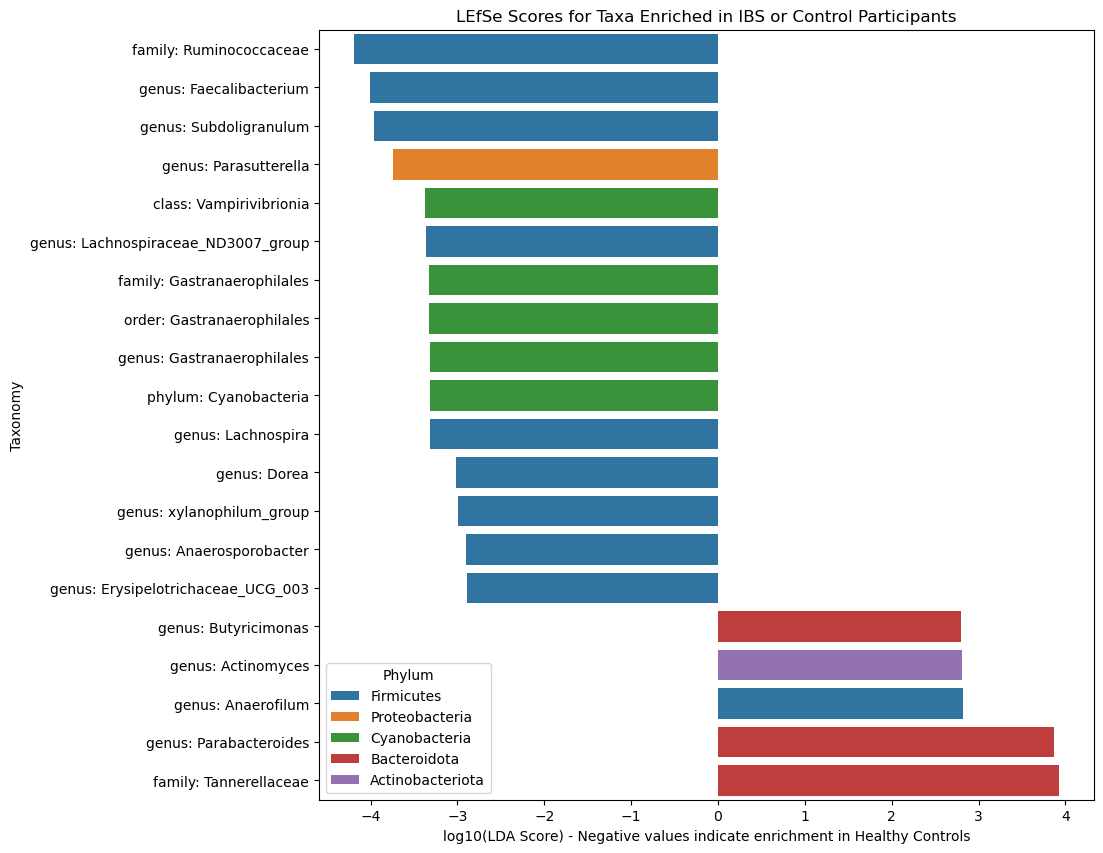

In [63]:
ax = sns.barplot(x="LDA Score (log10)",
                y="plotnames",
                hue="Phylum",
                data=res_sig[(np.abs(res_sig["LDA Score (log10)"]) > 2.8) & 
                             (res_sig["Phylum"]!="NA")],
                dodge=False)


ax.set_ylabel("Taxonomy")
ax.set_title("LEfSe Scores for Taxa Enriched in IBS or Control Participants", fontsize="large")
ax.set_xlabel("log10(LDA Score) - Negative values indicate enrichment in Healthy Controls")
plt.gcf().set_size_inches(10,10)
plt.savefig("Figures/LEfSe-IBS.pdf")
plt.show()

## Set up for subtypes

### IBS-C/CTRL

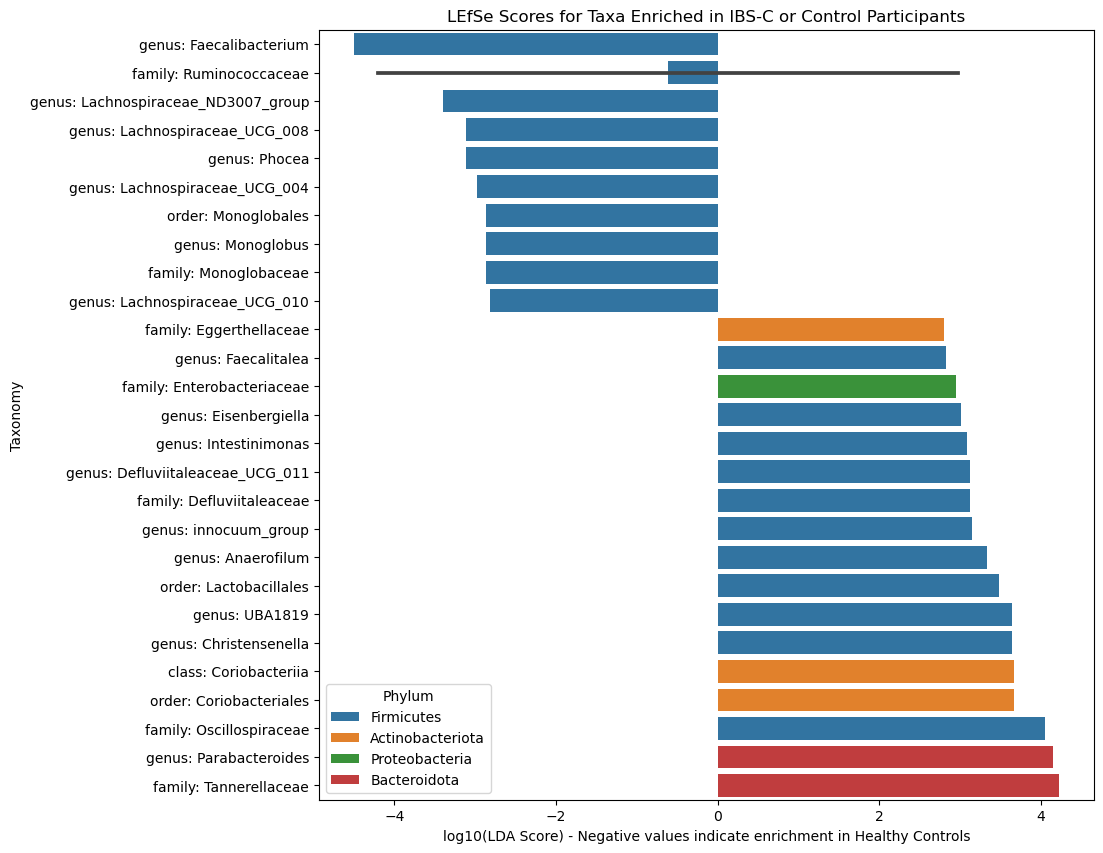

In [64]:
res = pd.read_csv("Data/Lefse-res/C_CTRL.lefse_internal_res", sep="\t",header=None)
res.rename(mapper={0: "Bacteria",
                   1: "Log10(highest class average)",
                   2: "Highest Class",
                   3: "LDA Score (log10)",
                   4: "p value"},
             axis=1, inplace=True)


res = res.drop(res[res["Bacteria"].apply(lambda x: "Unassigned" in x)].index)
res["plotnames"] = res["Bacteria"].apply(make_plotnames)

res['tax_split'] = res['Bacteria'].apply(taxonomy_splitter, splitter=".")

res['Domain'] = res['tax_split'].apply(lambda x: x[0])
res['Phylum'] = res['tax_split'].apply(lambda x: x[1])
res['Class'] = res['tax_split'].apply(lambda x: x[2])
res['Order'] = res['tax_split'].apply(lambda x: x[3])
res['Family'] = res['tax_split'].apply(lambda x: x[4])
res['Genus'] = res['tax_split'].apply(lambda x: x[5])
res['Species'] = res['tax_split'].apply(lambda x: x[6])
res.drop('tax_split', axis=1, inplace=True)

res.loc[res["Highest Class"]=="control","LDA Score (log10)"] = res.loc[res["Highest Class"]=="control","LDA Score (log10)"].apply(lambda x: -1*x)
res.sort_values("LDA Score (log10)", ascending=True, inplace=True)

res_sig = res[res["LDA Score (log10)"].isna()==False]

ax = sns.barplot(x="LDA Score (log10)",
                y="plotnames",
                hue="Phylum",
                data=res_sig[(np.abs(res_sig["LDA Score (log10)"]) > 2.8) & 
                             (res_sig["Phylum"]!="NA")],
                dodge=False)


ax.set_ylabel("Taxonomy")
ax.set_title("LEfSe Scores for Taxa Enriched in IBS-C or Control Participants", fontsize="large")
ax.set_xlabel("log10(LDA Score) - Negative values indicate enrichment in Healthy Controls")
plt.gcf().set_size_inches(10,10)
plt.savefig("Figures/LEfSe-C-CTRL.pdf")
plt.show()

### IBS-C/IBS-D

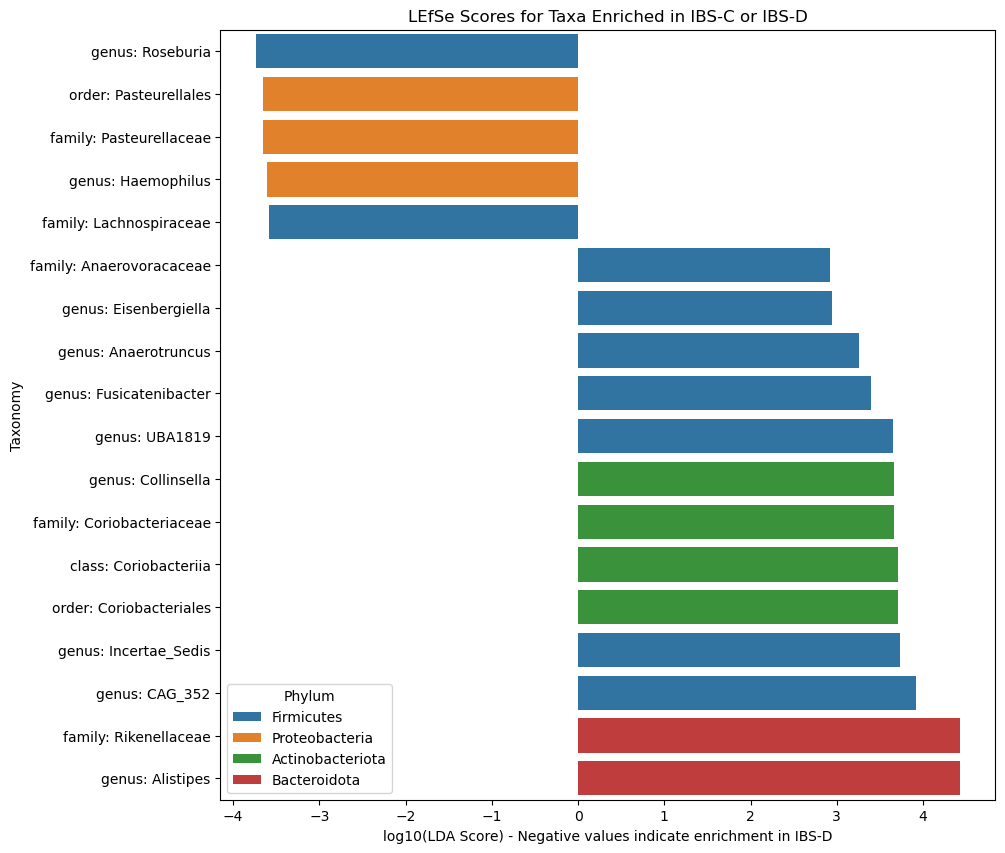

In [65]:
res = pd.read_csv("Data/Lefse-res/C_D.lefse_internal_res", sep="\t",header=None)
res.rename(mapper={0: "Bacteria",
                   1: "Log10(highest class average)",
                   2: "Highest Class",
                   3: "LDA Score (log10)",
                   4: "p value"},
             axis=1, inplace=True)


res = res.drop(res[res["Bacteria"].apply(lambda x: "Unassigned" in x)].index)
res["plotnames"] = res["Bacteria"].apply(make_plotnames)

res['tax_split'] = res['Bacteria'].apply(taxonomy_splitter, splitter=".")

res['Domain'] = res['tax_split'].apply(lambda x: x[0])
res['Phylum'] = res['tax_split'].apply(lambda x: x[1])
res['Class'] = res['tax_split'].apply(lambda x: x[2])
res['Order'] = res['tax_split'].apply(lambda x: x[3])
res['Family'] = res['tax_split'].apply(lambda x: x[4])
res['Genus'] = res['tax_split'].apply(lambda x: x[5])
res['Species'] = res['tax_split'].apply(lambda x: x[6])
res.drop('tax_split', axis=1, inplace=True)

res.loc[res["Highest Class"]=="IBS-D","LDA Score (log10)"] = res.loc[res["Highest Class"]=="IBS-D","LDA Score (log10)"].apply(lambda x: -1*x)
res.sort_values("LDA Score (log10)", ascending=True, inplace=True)

res_sig = res[res["LDA Score (log10)"].isna()==False]

ax = sns.barplot(x="LDA Score (log10)",
                y="plotnames",
                hue="Phylum",
                data=res_sig[(np.abs(res_sig["LDA Score (log10)"]) > 2.8) & 
                             (res_sig["Phylum"]!="NA")],
                dodge=False)


ax.set_ylabel("Taxonomy")
ax.set_title("LEfSe Scores for Taxa Enriched in IBS-C or IBS-D", fontsize="large")
ax.set_xlabel("log10(LDA Score) - Negative values indicate enrichment in IBS-D")
plt.gcf().set_size_inches(10,10)

plt.savefig("Figures/LEfSe-C-D.pdf")
plt.show()

### IBS-C/IBS-M

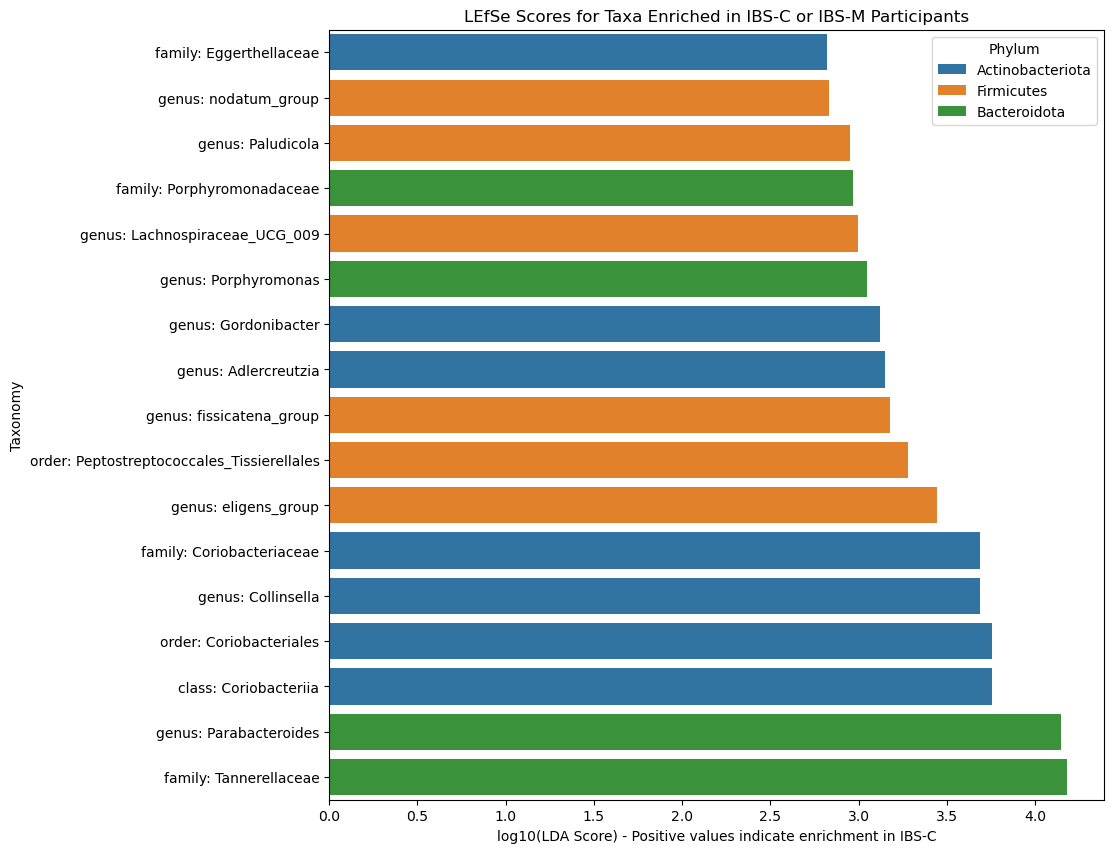

In [66]:
res = pd.read_csv("Data/Lefse-res/C_M.lefse_internal_res", sep="\t",header=None)
res.rename(mapper={0: "Bacteria",
                   1: "Log10(highest class average)",
                   2: "Highest Class",
                   3: "LDA Score (log10)",
                   4: "p value"},
             axis=1, inplace=True)


res = res.drop(res[res["Bacteria"].apply(lambda x: "Unassigned" in x)].index)
res["plotnames"] = res["Bacteria"].apply(make_plotnames)

res['tax_split'] = res['Bacteria'].apply(taxonomy_splitter, splitter=".")

res['Domain'] = res['tax_split'].apply(lambda x: x[0])
res['Phylum'] = res['tax_split'].apply(lambda x: x[1])
res['Class'] = res['tax_split'].apply(lambda x: x[2])
res['Order'] = res['tax_split'].apply(lambda x: x[3])
res['Family'] = res['tax_split'].apply(lambda x: x[4])
res['Genus'] = res['tax_split'].apply(lambda x: x[5])
res['Species'] = res['tax_split'].apply(lambda x: x[6])
res.drop('tax_split', axis=1, inplace=True)

res.loc[res["Highest Class"]=="IBS-M","LDA Score (log10)"] = res.loc[res["Highest Class"]=="IBS-M","LDA Score (log10)"].apply(lambda x: -1*x)
res.sort_values("LDA Score (log10)", ascending=True, inplace=True)

res_sig = res[res["LDA Score (log10)"].isna()==False]

ax = sns.barplot(x="LDA Score (log10)",
                y="plotnames",
                hue="Phylum",
                data=res_sig[(np.abs(res_sig["LDA Score (log10)"]) > 2.8) & 
                             (res_sig["Phylum"]!="NA")],
                dodge=False)


ax.set_ylabel("Taxonomy")
ax.set_title("LEfSe Scores for Taxa Enriched in IBS-C or IBS-M Participants", fontsize="large")
ax.set_xlabel("log10(LDA Score) - Positive values indicate enrichment in IBS-C")
plt.gcf().set_size_inches(10,10)

plt.savefig("Figures/LEfSe-C-M.pdf")
plt.show()

### IBS-M/IBS-D

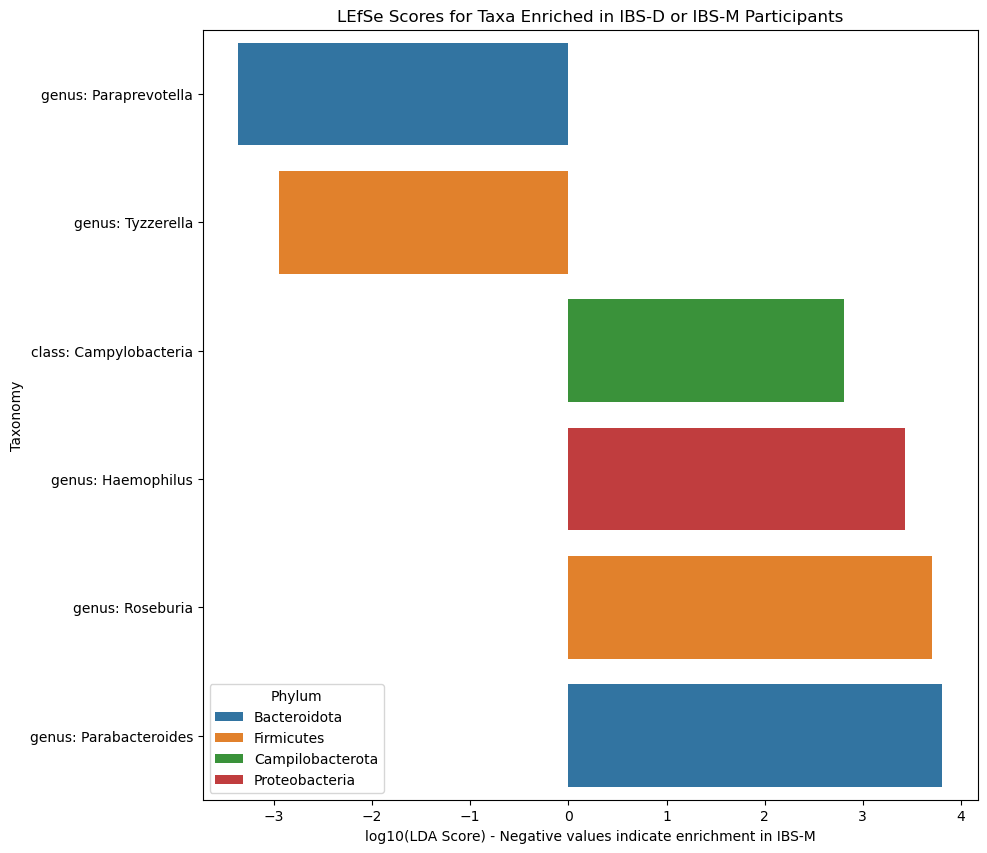

In [67]:
res = pd.read_csv("Data/Lefse-res/D_M.lefse_internal_res", sep="\t",header=None)
res.rename(mapper={0: "Bacteria",
                   1: "Log10(highest class average)",
                   2: "Highest Class",
                   3: "LDA Score (log10)",
                   4: "p value"},
             axis=1, inplace=True)


res = res.drop(res[res["Bacteria"].apply(lambda x: "Unassigned" in x)].index)
res["plotnames"] = res["Bacteria"].apply(make_plotnames)

res['tax_split'] = res['Bacteria'].apply(taxonomy_splitter, splitter=".")

res['Domain'] = res['tax_split'].apply(lambda x: x[0])
res['Phylum'] = res['tax_split'].apply(lambda x: x[1])
res['Class'] = res['tax_split'].apply(lambda x: x[2])
res['Order'] = res['tax_split'].apply(lambda x: x[3])
res['Family'] = res['tax_split'].apply(lambda x: x[4])
res['Genus'] = res['tax_split'].apply(lambda x: x[5])
res['Species'] = res['tax_split'].apply(lambda x: x[6])
res.drop('tax_split', axis=1, inplace=True)

res.loc[res["Highest Class"]=="IBS-M","LDA Score (log10)"] = res.loc[res["Highest Class"]=="IBS-M","LDA Score (log10)"].apply(lambda x: -1*x)
res.sort_values("LDA Score (log10)", ascending=True, inplace=True)

res_sig = res[res["LDA Score (log10)"].isna()==False]

ax = sns.barplot(x="LDA Score (log10)",
                y="plotnames",
                hue="Phylum",
                data=res_sig[(np.abs(res_sig["LDA Score (log10)"]) > 2.8) & 
                             (res_sig["Phylum"]!="NA")],
                dodge=False)


ax.set_ylabel("Taxonomy")
ax.set_title("LEfSe Scores for Taxa Enriched in IBS-D or IBS-M Participants", fontsize="large")
ax.set_xlabel("log10(LDA Score) - Negative values indicate enrichment in IBS-M")
plt.gcf().set_size_inches(10,10)

plt.savefig("Figures/LEfSe-M-D.pdf")
plt.show()

### IBS-M/CTRL

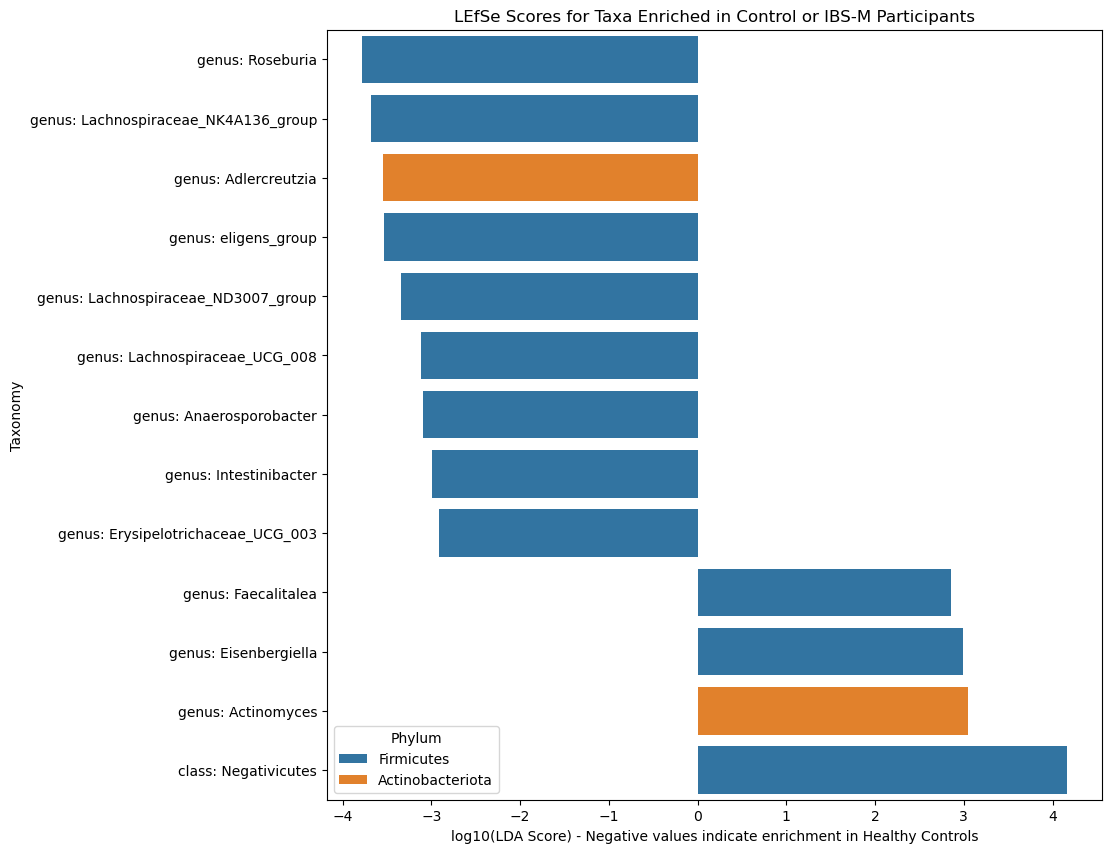

In [68]:
res = pd.read_csv("Data/Lefse-res/M_CTRL.lefse_internal_res", sep="\t",header=None)
res.rename(mapper={0: "Bacteria",
                   1: "Log10(highest class average)",
                   2: "Highest Class",
                   3: "LDA Score (log10)",
                   4: "p value"},
             axis=1, inplace=True)


res = res.drop(res[res["Bacteria"].apply(lambda x: "Unassigned" in x)].index)
res["plotnames"] = res["Bacteria"].apply(make_plotnames)

res['tax_split'] = res['Bacteria'].apply(taxonomy_splitter, splitter=".")

res['Domain'] = res['tax_split'].apply(lambda x: x[0])
res['Phylum'] = res['tax_split'].apply(lambda x: x[1])
res['Class'] = res['tax_split'].apply(lambda x: x[2])
res['Order'] = res['tax_split'].apply(lambda x: x[3])
res['Family'] = res['tax_split'].apply(lambda x: x[4])
res['Genus'] = res['tax_split'].apply(lambda x: x[5])
res['Species'] = res['tax_split'].apply(lambda x: x[6])
res.drop('tax_split', axis=1, inplace=True)

res.loc[res["Highest Class"]=="control","LDA Score (log10)"] = res.loc[res["Highest Class"]=="control","LDA Score (log10)"].apply(lambda x: -1*x)
res.sort_values("LDA Score (log10)", ascending=True, inplace=True)

res_sig = res[res["LDA Score (log10)"].isna()==False]

ax = sns.barplot(x="LDA Score (log10)",
                y="plotnames",
                hue="Phylum",
                data=res_sig[(np.abs(res_sig["LDA Score (log10)"]) > 2.8) & 
                             (res_sig["Phylum"]!="NA")],
                dodge=False)


ax.set_ylabel("Taxonomy")
ax.set_title("LEfSe Scores for Taxa Enriched in Control or IBS-M Participants", fontsize="large")
ax.set_xlabel("log10(LDA Score) - Negative values indicate enrichment in Healthy Controls")
plt.gcf().set_size_inches(10,10)

plt.savefig("Figures/LEfSe-M-CTRL.pdf")
plt.show()

### IBS-D/CTRL

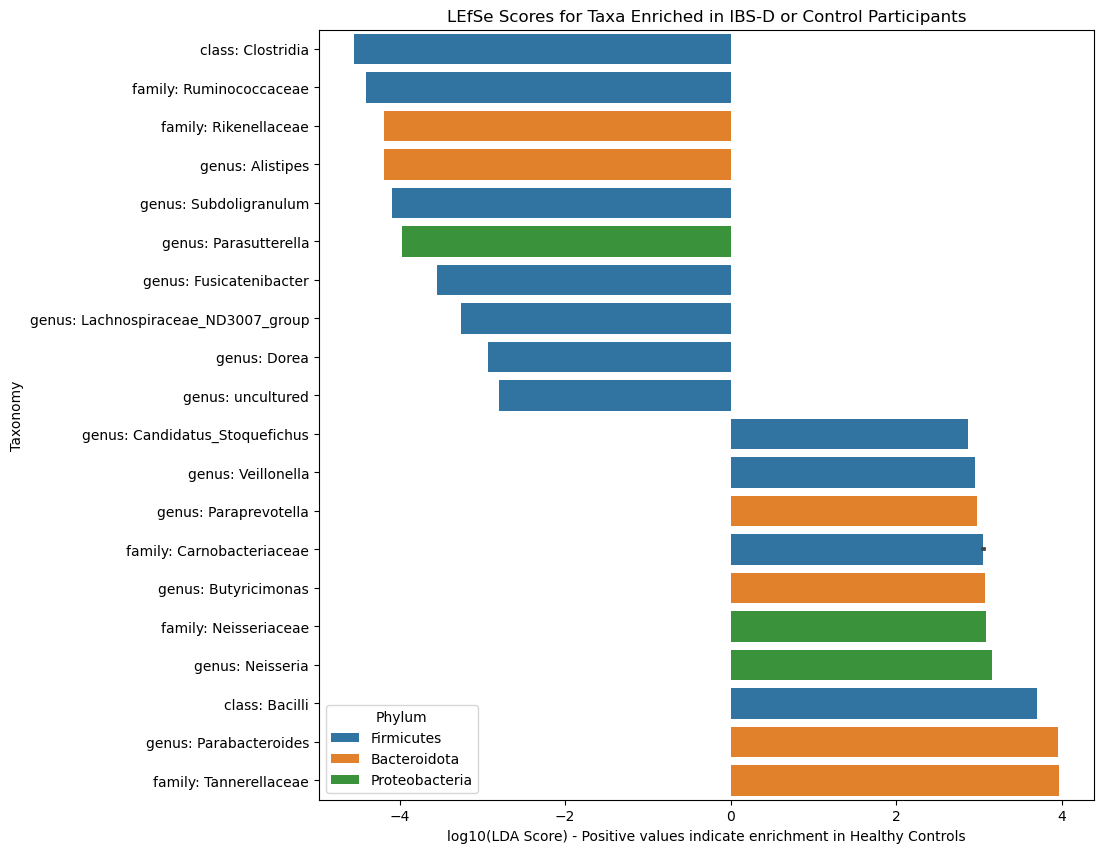

In [69]:
res = pd.read_csv("Data/Lefse-res/D_CTRL.lefse_internal_res", sep="\t",header=None)
res.rename(mapper={0: "Bacteria",
                   1: "Log10(highest class average)",
                   2: "Highest Class",
                   3: "LDA Score (log10)",
                   4: "p value"},
             axis=1, inplace=True)


res = res.drop(res[res["Bacteria"].apply(lambda x: "Unassigned" in x)].index)
res["plotnames"] = res["Bacteria"].apply(make_plotnames)

res['tax_split'] = res['Bacteria'].apply(taxonomy_splitter, splitter=".")

res['Domain'] = res['tax_split'].apply(lambda x: x[0])
res['Phylum'] = res['tax_split'].apply(lambda x: x[1])
res['Class'] = res['tax_split'].apply(lambda x: x[2])
res['Order'] = res['tax_split'].apply(lambda x: x[3])
res['Family'] = res['tax_split'].apply(lambda x: x[4])
res['Genus'] = res['tax_split'].apply(lambda x: x[5])
res['Species'] = res['tax_split'].apply(lambda x: x[6])
res.drop('tax_split', axis=1, inplace=True)

res.loc[res["Highest Class"]=="control","LDA Score (log10)"] = res.loc[res["Highest Class"]=="control","LDA Score (log10)"].apply(lambda x: -1*x)
res.sort_values("LDA Score (log10)", ascending=True, inplace=True)

res_sig = res[res["LDA Score (log10)"].isna()==False]

ax = sns.barplot(x="LDA Score (log10)",
                y="plotnames",
                hue="Phylum",
                data=res_sig[(np.abs(res_sig["LDA Score (log10)"]) > 2.8) & 
                             (res_sig["Phylum"]!="NA")],
                dodge=False)


ax.set_ylabel("Taxonomy")
ax.set_title("LEfSe Scores for Taxa Enriched in IBS-D or Control Participants", fontsize="large")
ax.set_xlabel("log10(LDA Score) - Positive values indicate enrichment in Healthy Controls")
plt.gcf().set_size_inches(10,10)

plt.savefig("Figures/LEfSe-D-CTRL.pdf")
plt.show()

# Phylum plot

In [70]:
phylum_df = tax_df.drop(modcolnames, axis=1).T.reset_index()
phylum_df["phylum"] = phylum_df["index"].apply(lambda x: taxonomy_splitter(x, splitter=";")[1])
phylum_df = phylum_df.drop("index", axis=1).groupby("phylum").sum()
phylum_df.drop(["","NA"], inplace=True)

phylum_df = phylum_df[phylum_df.mean(axis=1) > 0.005]

phylum_df = phylum_df.T
phylum_df[["IBS", "IBS Type"]] = tax_df[["IBS", "IBS-Type"]]
phylum_df["IBS"] = phylum_df["IBS"].apply(lambda x: class_mapper[x])

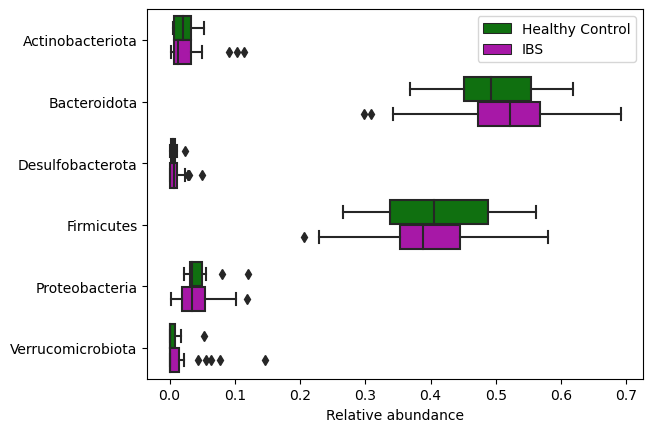

In [71]:
phylum_melted = pd.melt(phylum_df, id_vars=["IBS", "IBS Type"])

ax = sns.boxplot(y="phylum",
                x="value",
                hue="IBS",
                data=phylum_melted,
                palette=["g","m"])
ax.set_ylabel("")
ax.set_xlabel("Relative abundance")

ax.legend(title="")

plt.savefig("Figures/Phyla-IBS-boxplot.pdf")
plt.show()

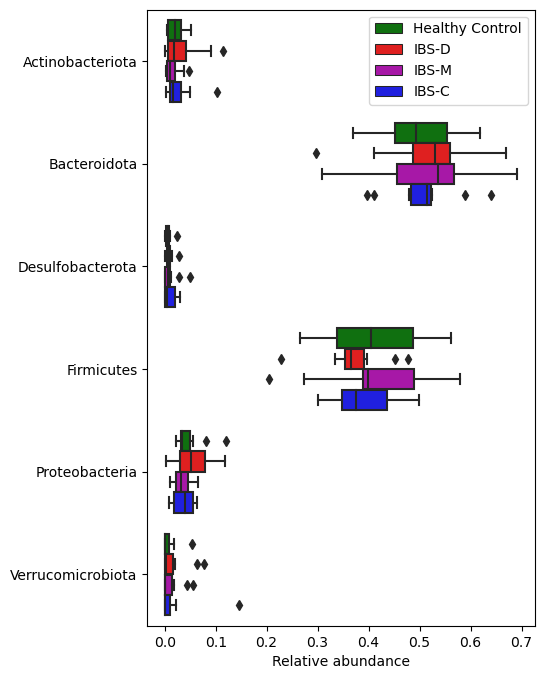

In [72]:
phylum_melted["IBS Type"] = phylum_melted["IBS Type"].apply(lambda x: "Healthy Control" if x=="control" else x)

ax = sns.boxplot(y="phylum",
                x="value",
                hue="IBS Type",
                data=phylum_melted,
                hue_order=["Healthy Control","IBS-D","IBS-M","IBS-C"],
                palette=["g","r","m","b"])

ax.set_ylabel("")
ax.set_xlabel("Relative abundance")

ax.legend(title="")
plt.gcf().set_size_inches(5,8)

plt.savefig("Figures/Phyla-IBS-Type-boxplot.pdf")
plt.show()

# Alpha div plots

/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_79742/4213919235.py:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x="IBS Type",


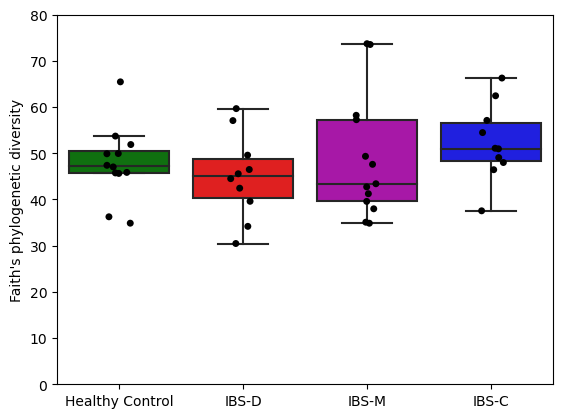

In [73]:
faith = Artifact.load("Data/faith_pd_vector.qza").view(pd.Series)
faith = pd.concat([faith,
                   metadata["IBS Type"]],
                 axis=1)

ax = sns.boxplot(x="IBS Type",
                y="faith_pd",
                data=faith,
                order=["control","IBS-D","IBS-M","IBS-C"],
                palette=["g","r","m","b"],
                showfliers=False)

sns.stripplot(x="IBS Type",
              y="faith_pd",
              data=faith,
              order=["control","IBS-D","IBS-M","IBS-C"],
              palette=["black"]*4,
              ax=ax)

ax.set_xticklabels(["Healthy Control","IBS-D","IBS-M","IBS-C"])
ax.set_xlabel("")
ax.set_ylabel("Faith's phylogenetic diversity")
ax.set_ylim(0,80)

plt.savefig("Figures/IBS-Type-Faith.pdf")

plt.show()

In [75]:
from scipy.stats import kruskal

kruskal(faith[faith["IBS Type"]=="control"]["faith_pd"],
        faith[faith["IBS Type"]=="IBS-M"]["faith_pd"],
        faith[faith["IBS Type"]=="IBS-D"]["faith_pd"],
        faith[faith["IBS Type"]=="IBS-C"]["faith_pd"])

KruskalResult(statistic=4.1556670382757375, pvalue=0.24513810579671094)

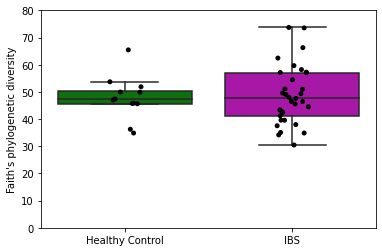

In [923]:
faith = Artifact.load("Data/faith_pd_vector.qza").view(pd.Series)
faith = pd.concat([faith,
                   metadata["IBS"]],
                 axis=1)

ax = sns.boxplot(x="IBS",
                y="faith_pd",
                data=faith,
                palette=["g","m"],
                showfliers=False)

sns.stripplot(x="IBS",
              y="faith_pd",
              data=faith,
              palette=["black"]*2,
              ax=ax)

ax.set_xticklabels(["Healthy Control","IBS"])
ax.set_xlabel("")
ax.set_ylabel("Faith's phylogenetic diversity")
ax.set_ylim(0,80)

plt.savefig("Figures/IBS-Faith.pdf")
plt.show()

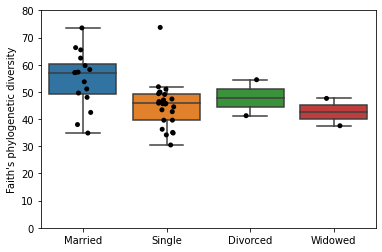

In [925]:
faith = Artifact.load("Data/faith_pd_vector.qza").view(pd.Series)
faith = pd.concat([faith,
                   metadata["Marrital sts"]],
                 axis=1)

ax = sns.boxplot(x="Marrital sts",
                y="faith_pd",
                data=faith,
                showfliers=False)

sns.stripplot(x="Marrital sts",
              y="faith_pd",
              data=faith,
              palette=["black"]*4,
              ax=ax)

ax.set_xlabel("")
ax.set_ylabel("Faith's phylogenetic diversity")
ax.set_ylim(0,80)

plt.savefig("Figures/Marital-Status-Faith.pdf")
plt.show()

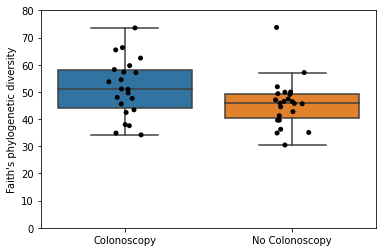

In [967]:
faith = Artifact.load("Data/faith_pd_vector.qza").view(pd.Series)
faith = pd.concat([faith,
                   metadata["Colonoscopy"]],
                 axis=1)

ax = sns.boxplot(x="Colonoscopy",
                y="faith_pd",
                data=faith,
                showfliers=False)

sns.stripplot(x="Colonoscopy",
              y="faith_pd",
              data=faith,
              palette=["black"]*2,
              ax=ax)

ax.set_xlabel("")
ax.set_ylabel("Faith's phylogenetic diversity")
ax.set_ylim(0,80)
ax.set_xticklabels(["Colonoscopy", "No Colonoscopy"])

plt.savefig("Figures/Colonoscopy-Faith.pdf")
plt.show()

In [926]:
metadata.columns

Index(['Age', 'Sex', 'Educ', 'Race', 'Marrital sts', 'Curr zipcode',
       'HH income', 'BMI', 'People per HH', 'Smoke', 'Cig per day', 'Alcohol',
       'Drinks per week', 'Past H pylori infection', 'Curr H pylori infection',
       'IBS', 'IBS Type', 'IBS medications', 'Colonoscopy',
       'Colonoscopy outcome', 'Endoscopy', 'Endoscopy outcome', 'Hypertension',
       'Diabetes', 'High cholesterol', 'Depression', 'Level of Depression',
       'Antidepressant', 'Anxiety', 'Level of anxiety', 'PTSD', 'Bipolar',
       'Psychosis', 'Recreational Drugs', 'Food triggers', 'FODMAP diet',
       'TOTAL EST HFCS (per month in grams)',
       'TOTAL EST HFCS (per year in grams)', 'TOTAL HFCS per year (pounds)'],
      dtype='object')

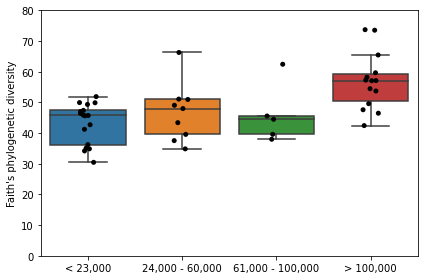

In [968]:
income_mapper = {"> 100,000": "> 100,000",
                 " >100,000": "> 100,000", 
                 ">100,000": "> 100,000", 
                 "upto 23,000": "< 23,000",
                 "< 23,000": "< 23,000",
                 "24,000-60,000": "24,000 - 60,000",
                 "24,000 - 60,000": "24,000 - 60,000",
                 "61,000-100,000": "61,000 - 100,000",
                 "61,000 - 100,000": "61,000 - 100,000"}
metadata["HH income"] = metadata["HH income"].apply(lambda x: income_mapper[x])

faith = Artifact.load("Data/faith_pd_vector.qza").view(pd.Series)
faith = pd.concat([faith,
                   metadata["HH income"]],
                 axis=1)

ax = sns.boxplot(x="HH income",
                y="faith_pd",
                data=faith,
                order=["< 23,000","24,000 - 60,000","61,000 - 100,000","> 100,000"],
                showfliers=False)

sns.stripplot(x="HH income",
              y="faith_pd",
              data=faith,
              order=["< 23,000","24,000 - 60,000","61,000 - 100,000","> 100,000"],
              palette=["black"]*4,
              ax=ax)

ax.set_xlabel("")
ax.set_ylabel("Faith's phylogenetic diversity")
ax.set_ylim(0,80)
plt.tight_layout()

plt.savefig("Figures/HHincome-Faith.pdf")
plt.show()

In [942]:
metadata.columns

Index(['Age', 'Sex', 'Educ', 'Race', 'Marrital sts', 'Curr zipcode',
       'HH income', 'BMI', 'People per HH', 'Smoke', 'Cig per day', 'Alcohol',
       'Drinks per week', 'Past H pylori infection', 'Curr H pylori infection',
       'IBS', 'IBS Type', 'IBS medications', 'Colonoscopy',
       'Colonoscopy outcome', 'Endoscopy', 'Endoscopy outcome', 'Hypertension',
       'Diabetes', 'High cholesterol', 'Depression', 'Level of Depression',
       'Antidepressant', 'Anxiety', 'Level of anxiety', 'PTSD', 'Bipolar',
       'Psychosis', 'Recreational Drugs', 'Food triggers', 'FODMAP diet',
       'TOTAL EST HFCS (per month in grams)',
       'TOTAL EST HFCS (per year in grams)', 'TOTAL HFCS per year (pounds)'],
      dtype='object')

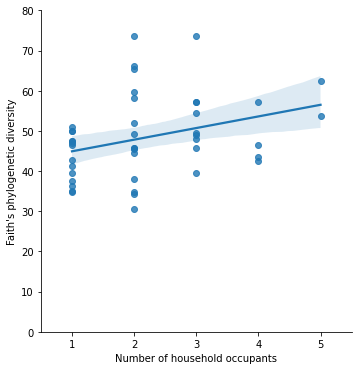

In [954]:
faith = Artifact.load("Data/faith_pd_vector.qza").view(pd.Series)
faith = pd.concat([faith,
                   metadata["People per HH"]],
                 axis=1)

g = sns.lmplot(x="People per HH",
                y="faith_pd",
                data=faith)

g.axes[0,0].set_xlabel("Number of household occupants")
g.axes[0,0].set_ylabel("Faith's phylogenetic diversity")

g.axes[0,0].set_xticks([1,2,3,4,5])

g.axes[0,0].set_xlim(0.5,5.5)
g.axes[0,0].set_ylim(0,80)

plt.savefig("Figures/HHoccupants-Faith.pdf")
plt.show()

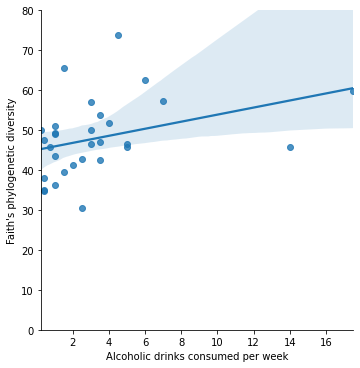

In [960]:
faith = Artifact.load("Data/faith_pd_vector.qza").view(pd.Series)
faith = pd.concat([faith,
                   metadata["Drinks per week"]],
                 axis=1)

g = sns.lmplot(x="Drinks per week",
                y="faith_pd",
                data=faith)

g.axes[0,0].set_xlabel("Alcoholic drinks consumed per week")
g.axes[0,0].set_ylabel("Faith's phylogenetic diversity")

g.axes[0,0].set_ylim(0,80)

plt.savefig("Figures/Drinksperweek-Faith.pdf")
plt.show()

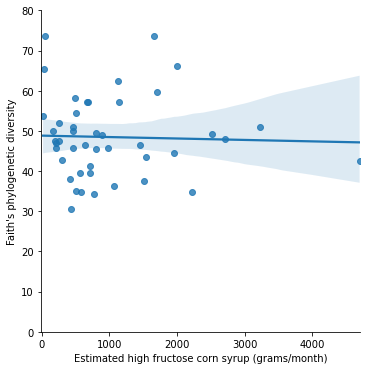

In [966]:
faith = Artifact.load("Data/faith_pd_vector.qza").view(pd.Series)
faith = pd.concat([faith,
                   metadata["TOTAL EST HFCS (per month in grams)"]],
                 axis=1)

g = sns.lmplot(x="TOTAL EST HFCS (per month in grams)",
                y="faith_pd",
                data=faith)

g.axes[0,0].set_xlabel("Estimated high fructose corn syrup (grams/month)")
g.axes[0,0].set_ylabel("Faith's phylogenetic diversity")

g.axes[0,0].set_ylim(0,80)
g.axes[0,0].set_xlim(-10)

plt.savefig("Figures/HFCS-Faith.pdf")
plt.show()